# Analyzing Police Activity with Pandas
- Traffic stops by Police Officers
- Collected by the Stanford Open Policing Project
- Focusing on the state of Rhode Island
- Each row represents a single traffic stop

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

### Examining and Cleaning the Data

In [79]:
ri_data = pd.read_csv('data/police.csv')
ri_data.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


#### Dealing with Null values

In [80]:
# Check out null values 
ri_data.isnull().sum()

state                     0
stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64

In [81]:
# Removing columns
# Remove state column and county_name as no additional information is given
ri_data = ri_data.drop(['county_name', 'state'], axis='columns')
ri_data.head()

,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


In [82]:
# Removing rows 
# Remove all rows where gender has not been entered
# Check percentage of data removed
print(f"Percentage of Data lost: {round((ri_data['driver_gender'].isnull().sum()/len(ri_data))*100,2)}%")

Percentage of Data lost: 5.67%


In [83]:
ri_data = ri_data.dropna(subset=['driver_gender'])
ri_data.isnull().sum()

stop_date                 0
stop_time                 0
driver_gender             0
driver_race               0
violation_raw             0
violation                 0
search_conducted          0
search_type           83229
stop_outcome              0
is_arrested               0
stop_duration             0
drugs_related_stop        0
district                  0
dtype: int64

**- Have kept the search_type column as it is relevant to the search_conducted column and as only relevant to these rows**

#### Changing datatypes 

In [84]:
ri_data.dtypes

stop_date             object
stop_time             object
driver_gender         object
driver_race           object
violation_raw         object
violation             object
search_conducted        bool
search_type           object
stop_outcome          object
is_arrested           object
stop_duration         object
drugs_related_stop      bool
district              object
dtype: object

In [85]:
# Change is_arrested to bool 
ri_data['is_arrested'] = ri_data['is_arrested'].astype(bool)
ri_data['is_arrested'].dtype

dtype('bool')

In [86]:
# Create datetime for stop_date and stop_time columns 
date_time = ri_data['stop_date'].str.cat(ri_data['stop_time'], sep=' ')

# Add column to dataframe
ri_data['stop_datetime'] = pd.to_datetime(date_time)

In [87]:
ri_data.dtypes

stop_date                     object
stop_time                     object
driver_gender                 object
driver_race                   object
violation_raw                 object
violation                     object
search_conducted                bool
search_type                   object
stop_outcome                  object
is_arrested                     bool
stop_duration                 object
drugs_related_stop              bool
district                      object
stop_datetime         datetime64[ns]
dtype: object

In [88]:
# Set datetime column as index
ri_data.set_index(ri_data['stop_datetime'], inplace=True)
ri_data.index

DatetimeIndex(['2005-01-04 12:55:00', '2005-01-23 23:15:00',
               '2005-02-17 04:15:00', '2005-02-20 17:15:00',
               '2005-02-24 01:20:00', '2005-03-14 10:00:00',
               '2005-03-29 21:55:00', '2005-04-04 21:25:00',
               '2005-07-14 11:20:00', '2005-07-14 19:55:00',
               ...
               '2015-12-31 13:23:00', '2015-12-31 18:59:00',
               '2015-12-31 19:13:00', '2015-12-31 20:20:00',
               '2015-12-31 20:50:00', '2015-12-31 21:21:00',
               '2015-12-31 21:59:00', '2015-12-31 22:04:00',
               '2015-12-31 22:09:00', '2015-12-31 22:47:00'],
              dtype='datetime64[ns]', name='stop_datetime', length=86536, freq=None)

### Analyzing relationships between gender and violations
#### Proportions of violations for each gender

In [89]:
# Have a look at violation proportionss
ri_data['violation'].value_counts(normalize=True)

Speeding               0.559571
Moving violation       0.187483
Equipment              0.126202
Other                  0.050950
Registration/plates    0.042791
Seat belt              0.033004
Name: violation, dtype: float64

In [90]:
# Separate genders
female = ri_data[ri_data['driver_gender']=='F']
male = ri_data[ri_data['driver_gender']=='M']

In [91]:
# Female violation proportions
female['violation'].value_counts(normalize=True)

Speeding               0.658114
Moving violation       0.138218
Equipment              0.105199
Registration/plates    0.044418
Other                  0.029738
Seat belt              0.024312
Name: violation, dtype: float64

In [92]:
male['violation'].value_counts(normalize=True)

Speeding               0.522243
Moving violation       0.206144
Equipment              0.134158
Other                  0.058985
Registration/plates    0.042175
Seat belt              0.036296
Name: violation, dtype: float64

#### Does gender affect who gets a ticket for speeding?

In [93]:
female_and_speeding = ri_data[(ri_data['driver_gender'] == 'F') & (ri_data['violation'] == 'Speeding')]


In [94]:
male_and_speeding = ri_data[(ri_data['driver_gender'] == 'M') & (ri_data['violation'] == 'Speeding')]


In [95]:
female_and_speeding['stop_outcome'].value_counts(normalize=True)

Citation            0.952192
Warning             0.040074
Arrest Driver       0.005752
N/D                 0.000959
Arrest Passenger    0.000639
No Action           0.000383
Name: stop_outcome, dtype: float64

In [96]:
male_and_speeding['stop_outcome'].value_counts(normalize=True)

Citation            0.944595
Warning             0.036184
Arrest Driver       0.015895
Arrest Passenger    0.001281
No Action           0.001068
N/D                 0.000976
Name: stop_outcome, dtype: float64

#### Does gender affect whose vechicle is searched?

In [97]:
# Find overall search rate
print(f"Overall search rate: {round(ri_data['search_conducted'].mean()*100, 2)}%")

Overall search rate: 3.82%


In [98]:
# Search rate for females
print(f"Female search rate: {round(ri_data[ri_data['driver_gender'] == 'F'].search_conducted.mean()*100, 2)}%")

Female search rate: 1.92%


In [99]:
# Search rate for males
print(f"Male search rate: {round(ri_data[ri_data['driver_gender'] == 'M'].search_conducted.mean()*100, 2)}%")

Male search rate: 4.54%


In [100]:
# Groupby violation and gender 
ri_data.groupby(['violation', 'driver_gender']).search_conducted.mean()

violation            driver_gender
Equipment            F                0.039984
                     M                0.071496
Moving violation     F                0.039257
                     M                0.061524
Other                F                0.041018
                     M                0.046191
Registration/plates  F                0.054924
                     M                0.108802
Seat belt            F                0.017301
                     M                0.035119
Speeding             F                0.008309
                     M                0.027885
Name: search_conducted, dtype: float64

#### Does gender affect who is frisked during a search?

In [101]:
ri_data['search_type'].value_counts()

Incident to Arrest                                          1290
Probable Cause                                               924
Inventory                                                    219
Reasonable Suspicion                                         214
Protective Frisk                                             164
Incident to Arrest,Inventory                                 123
Incident to Arrest,Probable Cause                            100
Probable Cause,Reasonable Suspicion                           54
Incident to Arrest,Inventory,Probable Cause                   35
Probable Cause,Protective Frisk                               35
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      25
Protective Frisk,Reasonable Suspicion                         19
Incident to Arrest,Inventory,Protective Frisk                 18
Incident to Arrest,Probable Cause,Protective Frisk            13
Inventory,Protective Fris

- For some cases multiple actions were taken. 
- Want to check all the cases where there was a frisk

In [102]:
ri_data['frisk'] = ri_data['search_type'].str.contains('Protective Frisk', na=False)

In [103]:
ri_data['frisk'].sum()

303

In [104]:
# Frisk rate for males and females
searched = ri_data[ri_data['search_conducted'] == True] # Isolate where searches were conducted
print(f"Searches where frisks happened: {round(searched['frisk'].mean()*100, 2)}%")

Searches where frisks happened: 9.16%


In [105]:
# Sort by gender
searched.groupby('driver_gender').frisk.mean()

driver_gender
F    0.074561
M    0.094353
Name: frisk, dtype: float64

### Visual exploratory data analysis
#### Does time of day affest arrest rate?


In [106]:
# Total arrest mean
print(f"Total arrest rate: {round(ri_data['is_arrested'].mean()*100, 2)}%")

Total arrest rate: 3.56%


In [107]:
# Mean per hour
hourly_arrest_rate = round(ri_data.groupby(ri_data.index.hour).is_arrested.mean()*100,2)
hourly_arrest_rate

stop_datetime
0     5.14
1     6.49
2     6.08
3     6.05
4     4.80
5     4.28
6     1.38
7     1.30
8     2.19
9     2.52
10    2.82
11    2.89
12    3.74
13    3.08
14    3.06
15    3.07
16    3.53
17    4.06
18    3.82
19    3.22
20    3.81
21    6.45
22    4.87
23    4.76
Name: is_arrested, dtype: float64

- Mean arrest rate is higher between 9pm and 5am
- Quieter roads? More crimes committed between these times?

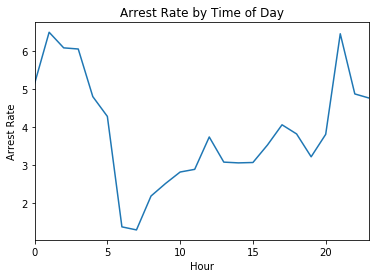

In [108]:
hourly_arrest_rate.plot()
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')
plt.show()

#### Are drug related stops on the rise?

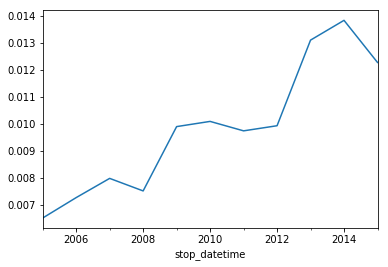

In [109]:
# Drug related stops
annual_drug_rate = ri_data['drugs_related_stop'].resample('A').mean()
annual_drug_rate.plot();

- The rate of drug related stops has been increasing until 2014 where there was a decline. 
- Has almost doubled in 9 years

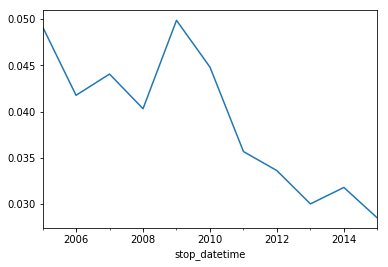

In [110]:
# Search rate
annual_search_rate = ri_data['search_conducted'].resample('A').mean()
annual_search_rate.plot()

- However search rates have been declining over this time

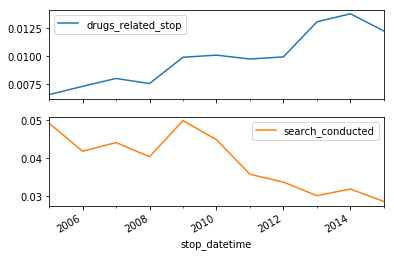

In [111]:
annual = pd.concat([annual_drug_rate, annual_search_rate], axis='columns')
annual.plot(subplots=True);

#### What violations are caught in each district?
- Introduction to crosstab()
- Pass two pandas series' (or two Df columns) of categories and it outputs a frequency table in the form of a dataframe

In [112]:
table = pd.crosstab(ri_data.driver_race, ri_data.driver_gender)
table

driver_gender,F,M
driver_race,,
Asian,551,1838
Black,2681,9604
Hispanic,1953,7774
Other,53,212
White,18536,43334


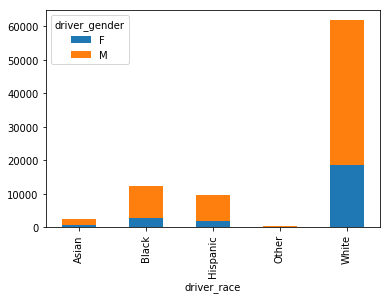

In [113]:
table.plot(kind='bar', stacked=True);

#### Violations by district

In [114]:
all_zones = pd.crosstab(ri_data.district, ri_data.violation)
all_zones

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
district,,,,,,
Zone K1,672,1254,290,120,0,5960
Zone K2,2061,2962,942,768,481,10448
Zone K3,2302,2898,705,695,638,12322
Zone X1,296,671,143,38,74,1119
Zone X3,2049,3086,769,671,820,8779
Zone X4,3541,5353,1560,1411,843,9795


In [115]:
k_zones = all_zones.loc['Zone K1': 'Zone K3']
x_zones = all_zones.loc['Zone X1': 'Zone X4']

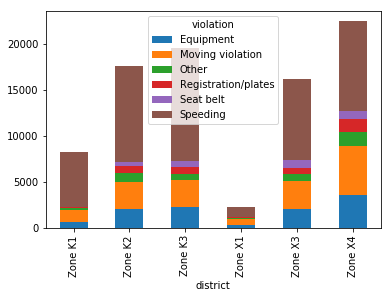

In [116]:
all_zones.plot(kind='bar', stacked=True);

- Across each district, speeding is the highest proportion of violations
- Followed by moving violations

#### How long might you be stopped for a violation?

In [117]:
# Convert strings to mean value using mapping 
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min': 45}

# Add column
ri_data['stop_minutes'] = ri_data['stop_duration'].map(mapping)
ri_data['stop_minutes'].unique()

array([ 8, 23, 45])

In [118]:
stop_length = ri_data.groupby('violation_raw').mean()['stop_minutes']
stop_length

violation_raw
APB                                 17.967033
Call for Service                    22.124371
Equipment/Inspection Violation      11.445655
Motorist Assist/Courtesy            17.741463
Other Traffic Violation             13.844490
Registration Violation              13.736970
Seatbelt Violation                   9.662815
Special Detail/Directed Patrol      15.123632
Speeding                            10.581562
Suspicious Person                   14.910714
Violation of City/Town Ordinance    13.254144
Warrant                             24.055556
Name: stop_minutes, dtype: float64

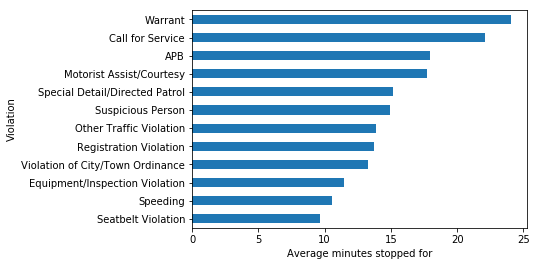

In [119]:
stop_length.sort_values().plot(kind='barh')
plt.xlabel('Average minutes stopped for')
plt.ylabel('Violation');

### Analysing the effect of weather on policing
**Hypothesis:** Weather conditions impact police bahviour during traffic stops   
*(Data from a single weather station in RI - not available for each particular stop)*

In [120]:
# Import weather data 
weather = pd.read_csv('data/providence_weather.csv')
weather.head()

,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


#### Analyzing Temperature

In [121]:
# Analyse temperature columns
weather[['TMIN', 'TAVG', 'TMAX']].describe()

,TMIN,TAVG,TMAX
count,4017.000000,1217.000000,4017.000000
mean,43.484441,52.493016,61.268608
std,17.020298,17.830714,18.199517
min,-5.000000,6.000000,15.000000
25%,30.000000,39.000000,47.000000
50%,44.000000,54.000000,62.000000
75%,58.000000,68.000000,77.000000
max,77.000000,86.000000,102.000000


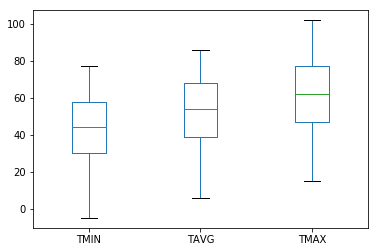

In [122]:
weather[['TMIN', 'TAVG', 'TMAX']].plot(kind='box');

In [123]:
# Create Temperature Difference column 
weather['TDIFF'] = weather['TMAX'] - weather['TMIN']
weather['TDIFF'].describe()

count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64

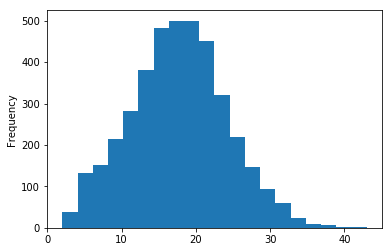

In [124]:
weather['TDIFF'].plot(kind='hist', bins=20);

#### Analyzing Bad Weather conditions
Each column in weather starting with WT indicates a bad weather condition e.g. Hail / Freezing Rain / High Winds

In [125]:
# Isolate bad weather conditions
WT = weather.loc[:, 'WT01': 'WT22']
WT.head()

,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


In [126]:
# Sum each row to see how many bad conditions occurred each day
weather['bad_conditions'] = WT.sum(axis='columns')
# Fill nulls with zero 
weather['bad_conditions'] = weather['bad_conditions'].fillna(0).astype('int')

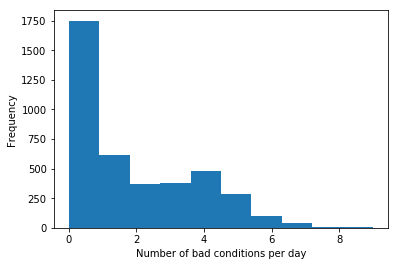

In [127]:
weather['bad_conditions'].plot(kind='hist')
plt.xlabel('Number of bad conditions per day');

#### Rating Weather Conditions

In [128]:
# Create mapping dictionary
map_list = []
numbers = list(range(0,10))

for item in numbers:
    if item >= 5: 
        map_list.append('worse')      
    if 5 > item >=1:
        map_list.append('bad')
    if item == 0:
        map_list.append('good')
        
mapping = dict(zip(numbers, map_list))
mapping        

{0: 'good',
 1: 'bad',
 2: 'bad',
 3: 'bad',
 4: 'bad',
 5: 'worse',
 6: 'worse',
 7: 'worse',
 8: 'worse',
 9: 'worse'}

In [129]:
weather['rating'] = weather['bad_conditions'].map(mapping)
weather['rating'].value_counts()

bad      1836
good     1749
worse     432
Name: rating, dtype: int64

In [130]:
# Change to ordered category column
cat_type = CategoricalDtype(categories=["worse", 'bad', 'good'], ordered=True)

weather['rating'] = weather['rating'].astype(cat_type)
weather['rating'].head()

0    bad
1    bad
2    bad
3    bad
4    bad
Name: rating, dtype: category
Categories (3, object): [worse < bad < good]

#### Merge weather and police data

In [131]:
weather_rating = weather[['DATE', 'rating']]
weather_rating.head()

,DATE,rating
0,2005-01-01,bad
1,2005-01-02,bad
2,2005-01-03,bad
3,2005-01-04,bad
4,2005-01-05,bad


In [132]:
# Add new weather_rating to ri_data
ri_weather = pd.merge(left=ri_data, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

In [133]:
ri_weather = ri_weather.set_index('stop_datetime')
ri_weather.head()

,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,frisk,stop_minutes,DATE,rating
stop_datetime,,,,,,,,,,,,,,,,,
2005-01-04 12:55:00,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,2005-01-04,bad
2005-01-23 23:15:00,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False,8,2005-01-23,worse
2005-02-17 04:15:00,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,2005-02-17,good
2005-02-20 17:15:00,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,False,23,2005-02-20,bad
2005-02-24 01:20:00,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,False,8,2005-02-24,bad


#### Arrest rates by weather rating:

In [134]:
ri_weather.groupby('rating').is_arrested.mean()

rating
worse    0.041667
bad      0.036261
good     0.033715
Name: is_arrested, dtype: float64

#### Arrest rate per violation in each weather condition

In [136]:
arrest_rate = ri_weather.groupby(['violation', 'rating']).is_arrested.mean()
arrest_rate

violation            rating
Equipment            worse     0.097357
                     bad       0.066311
                     good      0.059007
Moving violation     worse     0.065860
                     bad       0.058050
                     good      0.056227
Other                worse     0.062893
                     bad       0.087443
                     good      0.076966
Registration/plates  worse     0.115625
                     bad       0.098160
                     good      0.081574
Seat belt            worse     0.000000
                     bad       0.022493
                     good      0.028587
Speeding             worse     0.016886
                     bad       0.013314
                     good      0.013405
Name: is_arrested, dtype: float64

In [138]:
# Accessing data in the Series
arrest_rate['Moving violation']['bad']

0.05804964058049641

In [140]:
# Reshape
violations = ri_weather.pivot_table(index='violation', columns='rating', values='is_arrested')
violations

rating,worse,bad,good
violation,,,
Equipment,0.097357,0.066311,0.059007
Moving violation,0.065860,0.058050,0.056227
Other,0.062893,0.087443,0.076966
Registration/plates,0.115625,0.098160,0.081574
Seat belt,0.000000,0.022493,0.028587
Speeding,0.016886,0.013314,0.013405


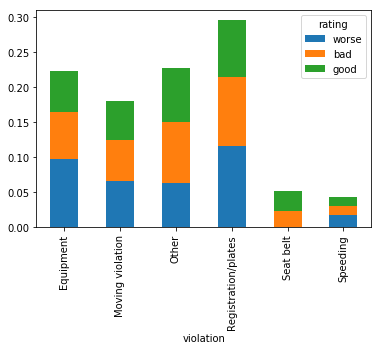

In [143]:
violations.plot(kind='bar', stacked=True);

- Seat belt violations are 0% when the weather is at its worst
- However, other violations such as Reg/Plates, equipment and speeding are highest during the worst weather.
- Speeding is more dangerous during bad weather, therefore this would maybe support why arrests for speeding are higher during this time?

---